In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from glob import glob
import random
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from torch import nn
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score

In [2]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(0)

In [3]:
df = pd.read_csv("../datasets/waterbird/metadata.csv")
df.head(5)

,img_id,img_filename,y,split,place,place_filename
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...,1,2,1,/o/ocean/00002178.jpg
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...,1,0,1,/l/lake/natural/00000065.jpg
2,3,001.Black_footed_Albatross/Black_Footed_Albatr...,1,2,0,/b/bamboo_forest/00000131.jpg
3,4,001.Black_footed_Albatross/Black_Footed_Albatr...,1,0,1,/o/ocean/00001268.jpg
4,5,001.Black_footed_Albatross/Black_Footed_Albatr...,1,0,1,/o/ocean/00003147.jpg


In [4]:
LANDBIRD = 0
WATERBIRD = 1
LAND = 0
WATER = 1

In [5]:
def get_result(result_file: str):
    performance_report = np.load(result_file, allow_pickle=True)

    true_labels = np.array([x['img_label'] for x in performance_report])
    predicted_labels = np.array([x['predicted'] for x in performance_report])
    place = [x['place'] for x in performance_report]

    landbird_on_land = []
    landbird_on_water = []
    waterbird_on_land = []
    waterbird_on_water = []

    predicted_landbird_on_land = []
    predicted_landbird_on_water = []
    predicted_waterbird_on_land = []
    predicted_waterbird_on_water = []

    predicted_landbird_on_land_correct = []
    predicted_landbird_on_land_incorrect = []

    predicted_landbird_on_water_correct = []
    predicted_landbird_on_water_incorrect = []

    predicted_waterbird_on_land_correct = []
    predicted_waterbird_on_land_incorrect = []

    predicted_waterbird_on_water_correct = []
    predicted_waterbird_on_water_incorrect = []

    for report in performance_report:
        if report['img_label'] == LANDBIRD and report['place'] == LAND:
            landbird_on_land.append(report['img_label'])
            predicted_landbird_on_land.append(report['predicted'])
            if report['img_label'] == report['predicted']:
                predicted_landbird_on_land_correct.append(report)
            else:
                predicted_landbird_on_land_incorrect.append(report)

        elif report['img_label'] == LANDBIRD and report['place'] == WATER:
            landbird_on_water.append(report['img_label'])
            predicted_landbird_on_water.append(report['predicted'])
            if report['img_label'] == report['predicted']:
                predicted_landbird_on_water_correct.append(report)
            else:
                predicted_landbird_on_water_incorrect.append(report)

        elif report['img_label'] == WATERBIRD and report['place'] == LAND:
            waterbird_on_land.append(report['img_label'])
            predicted_waterbird_on_land.append(report['predicted'])
            if report['img_label'] == report['predicted']:
                predicted_waterbird_on_land_correct.append(report)
            else:
                predicted_waterbird_on_land_incorrect.append(report)

        elif report['img_label'] == WATERBIRD and report['place'] == WATER:
            waterbird_on_water.append(report['img_label'])
            predicted_waterbird_on_water.append(report['predicted'])
            if report['img_label'] == report['predicted']:
                predicted_waterbird_on_water_correct.append(report)
            else:
                predicted_waterbird_on_water_incorrect.append(report)



    test_acc = accuracy_score(true_labels, predicted_labels)
    landbird_on_land_acc = accuracy_score(landbird_on_land, predicted_landbird_on_land)
    landbird_on_water_acc = accuracy_score(landbird_on_water, predicted_landbird_on_water)
    waterbird_on_water_acc = accuracy_score(waterbird_on_water, predicted_waterbird_on_water)
    waterbird_on_land_acc = accuracy_score(waterbird_on_land, predicted_waterbird_on_land)

    test_f1 = f1_score(true_labels, predicted_labels, average='macro')
    landbird_on_land_f1 = f1_score(landbird_on_land, predicted_landbird_on_land, average='macro')
    landbird_on_water_f1 = f1_score(landbird_on_water, predicted_landbird_on_water, average='macro')
    waterbird_on_water_f1 = f1_score(waterbird_on_water, predicted_waterbird_on_water, average='macro')
    waterbird_on_land_f1 = f1_score(waterbird_on_land, predicted_waterbird_on_land, average='macro')


    # print(f"All data\nAccuracy: {test_acc:.2f} | F1 Score: {test_f1:.2f}")
    # print(f"Landbird on land\nAccuracy: {landbird_on_land_acc:.2f} | F1 Score: {landbird_on_land_f1:.2f}")
    # print(f"Landbird on water\nAccuracy: {landbird_on_water_acc:.2f} | F1 Score: {landbird_on_water_f1:.2f}")
    # print(f"Waterbird on water\nAccuracy: {waterbird_on_water_acc:.2f} | F1 Score: {waterbird_on_water_f1:.2f}")
    # print(f"Waterbird on land\nAccuracy: {waterbird_on_land_acc:.2f} | F1 Score: {waterbird_on_land_f1:.2f}")

    return test_acc, landbird_on_land_acc, landbird_on_water_acc, waterbird_on_land_acc, waterbird_on_water_acc, test_f1, landbird_on_land_f1, landbird_on_water_f1, waterbird_on_land_f1, waterbird_on_water_f1

In [20]:
model_name = 'Resnet152'

result = {
    'model_name': model_name,
    'sample_size': [],
    'test_acc_mean': [],
    'landbird_on_land_acc_mean': [],
    'landbird_on_water_acc_mean': [],
    'waterbird_on_land_acc_mean': [],
    'waterbird_on_water_acc_mean': [],
    'test_acc_std': [],
    'landbird_on_land_acc_std': [],
    'landbird_on_water_acc_std': [],
    'waterbird_on_land_acc_std': [],
    'waterbird_on_water_acc_std': [],
}

for idx, sample_size in enumerate([100, 200, 400, 800]):
    test_accs = []
    landbird_on_land_accs = []
    landbird_on_water_accs = []
    waterbird_on_land_accs = []
    waterbird_on_water_accs = []
    for split in range(1, 4):

        augment_sample = f'{sample_size}_sample_{split}'

        test_acc, landbird_on_land_acc, \
        landbird_on_water_acc, waterbird_on_land_acc, \
        waterbird_on_water_acc, test_f1, \
        landbird_on_land_f1, landbird_on_water_f1, \
        waterbird_on_land_f1, waterbird_on_water_f1 = get_result(f"D:/Download/Waterbird/{model_name}/{augment_sample}/test_predictions_{augment_sample}.npy")

        test_accs.append(test_acc)
        landbird_on_land_accs.append(landbird_on_land_acc)
        landbird_on_water_accs.append(landbird_on_water_acc)
        waterbird_on_land_accs.append(waterbird_on_land_acc)
        waterbird_on_water_accs.append(waterbird_on_water_acc)

    test_acc_mean = np.mean(test_accs)
    landbird_on_land_acc_mean = np.mean(landbird_on_land_accs)
    landbird_on_water_acc_mean = np.mean(landbird_on_water_accs)
    waterbird_on_land_acc_mean = np.mean(waterbird_on_land_accs)
    waterbird_on_water_acc_mean = np.mean(waterbird_on_water_accs)

    test_acc_std = np.std(test_accs)
    landbird_on_land_acc_std = np.std(landbird_on_land_accs)
    landbird_on_water_acc_std = np.std(landbird_on_water_accs)
    waterbird_on_land_acc_std = np.std(waterbird_on_land_accs)
    waterbird_on_water_acc_std = np.std(waterbird_on_water_accs)

    result['sample_size'].append(sample_size)
    # mean
    result['test_acc_mean'].append(test_acc_mean)
    result['landbird_on_land_acc_mean'].append(landbird_on_land_acc_mean)
    result['landbird_on_water_acc_mean'].append(landbird_on_water_acc_mean)
    result['waterbird_on_land_acc_mean'].append(waterbird_on_land_acc_mean)
    result['waterbird_on_water_acc_mean'].append(waterbird_on_water_acc_mean)
    # std
    result['test_acc_std'].append(test_acc_std)
    result['landbird_on_land_acc_std'].append(landbird_on_land_acc_std)
    result['landbird_on_water_acc_std'].append(landbird_on_water_acc_std)
    result['waterbird_on_land_acc_std'].append(waterbird_on_land_acc_std)
    result['waterbird_on_water_acc_std'].append(waterbird_on_water_acc_std)

In [21]:
np.save('./resnet152_all_statistics.npy', result)

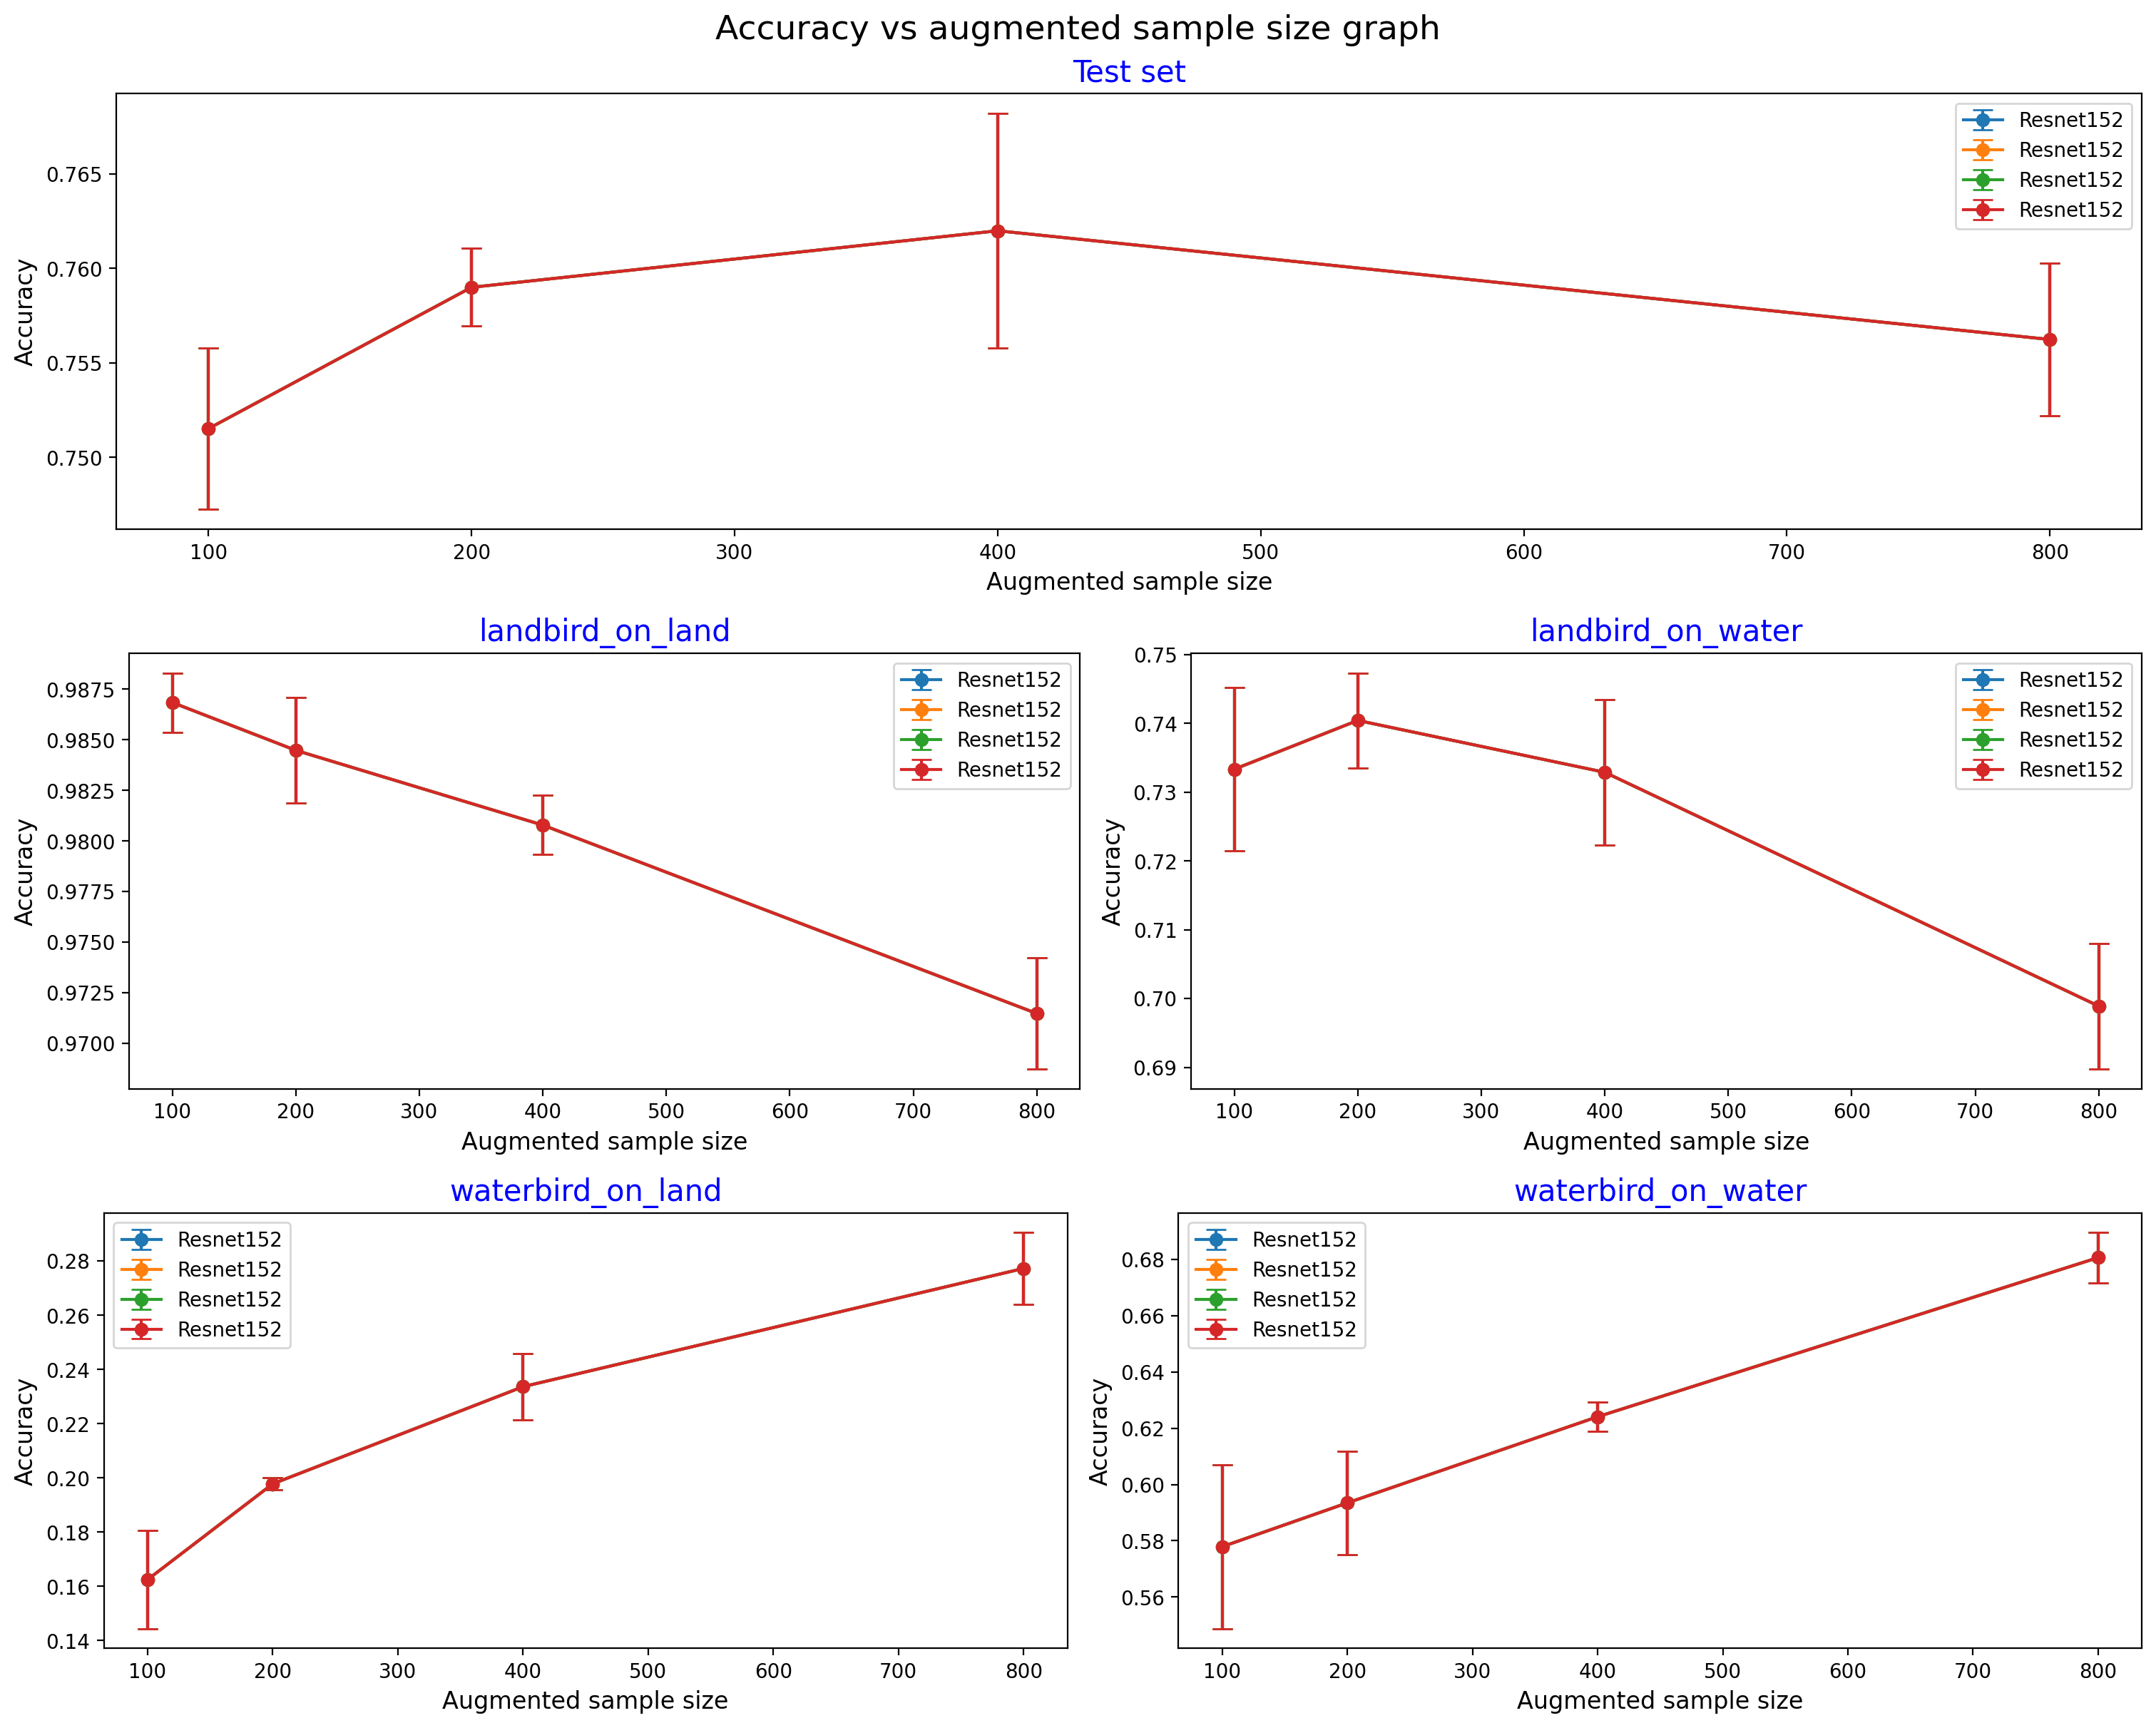

In [78]:
result_files = ["D:/Download/Waterbird/Resnet152/resnet152_all_statistics.npy"] * 4
groups = ['landbird_on_land', 'landbird_on_water', 'waterbird_on_land', 'waterbird_on_water']

fig = plt.figure(figsize=(15, 12), dpi=200, constrained_layout=True)
subfigs = fig.subfigures(nrows=3, ncols=1)
ax = subfigs[0].subplots(nrows=1, ncols=1)
fig.suptitle('Accuracy vs augmented sample size graph', fontsize=17)

for result_file in result_files:
    result_file = np.load(result_file, allow_pickle=True).item()
    sample_size = result_file['sample_size']
    mean_accuracy = result_file['test_acc_mean']
    std_dev = result_file['test_acc_std']

    ax.errorbar(sample_size, mean_accuracy, yerr=std_dev, fmt='-o', capsize=5, label=result_file['model_name'])

ax.set_title('Test set', fontsize=15, color='blue')
ax.legend()
ax.set_xlabel('Augmented sample size', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)

sub_row1, sub_row2 = subfigs[1], subfigs[2]
axs = list(sub_row1.subplots(nrows=1, ncols=2).flatten()) + list(sub_row2.subplots(nrows=1, ncols=2).flatten())

for group, ax in zip(groups, axs):
    for result_file in result_files:
        result_file = np.load(result_file, allow_pickle=True).item()
        sample_size = result_file['sample_size']
        mean_accuracy = result_file[f'{group}_acc_mean']
        std_dev = result_file[f'{group}_acc_std']
        
        ax.errorbar(sample_size, mean_accuracy, yerr=std_dev, fmt='-o', capsize=5, label=result_file['model_name'])
        ax.set_title(group, fontsize=15, color='blue')
    ax.legend()
    ax.set_xlabel('Augmented sample size', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)

plt.show()
